# Resolve more sources than the number of sensors using a co-prime array

In [1]:
import numpy as np
import doatools.model as model
import doatools.estimation as estimation
import doatools.plotting as doaplt
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
np.random.seed(113)

wavelength = 1.0 # normalized
d0 = wavelength / 2
# This co-prime array only have 9 elements.
cpa = model.CoPrimeArray(3, 4, d0)
# However, we have 10 sources here.
sources = model.FarField1DSourcePlacement(
    np.linspace(-np.pi/3, np.pi/3, 10)
)
# SNR = 0 dB
power_source = 1.0 # Sources share the same power.
power_noise = 1.0
n_snapshots = 100

# Generate snapshots according to the stochastic model.
source_signal = model.ComplexStochasticSignal(sources.size, power_source)
noise_signal = model.ComplexStochasticSignal(cpa.size, power_noise)
y, R = model.get_narrowband_snapshots(
    cpa, sources, wavelength, source_signal, noise_signal,
    n_snapshots, return_covariance=True
)

# Prepare the search grid.
grid = estimation.FarField1DSearchGrid(size=720)

## Apply MVDR directly

We assume that the number of sources is known.

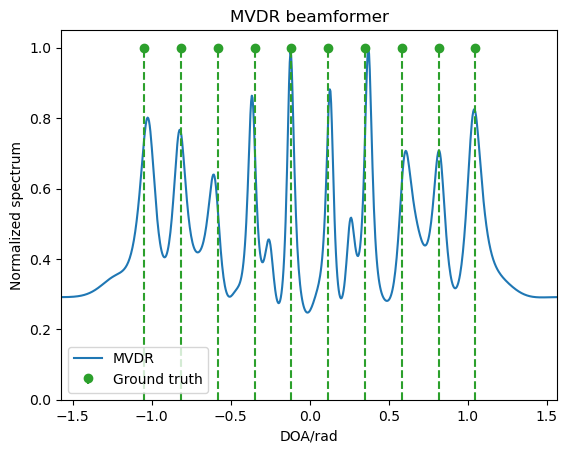

In [6]:
mvdr = estimation.MVDRBeamformer(cpa, wavelength, grid)
resv_mvdr, est_mvdr, sp_mvdr = mvdr.estimate(R, sources.size, return_spectrum=True)

plt.figure()
ax = plt.subplot(1, 1, 1)
doaplt.plot_spectrum({'MVDR': sp_mvdr}, grid, ax=ax, ground_truth=sources)
ax.set_title('MVDR beamformer')
plt.show()

## Use SS-MUSIC and DA-MUSIC

We assume that the number of sources is known.

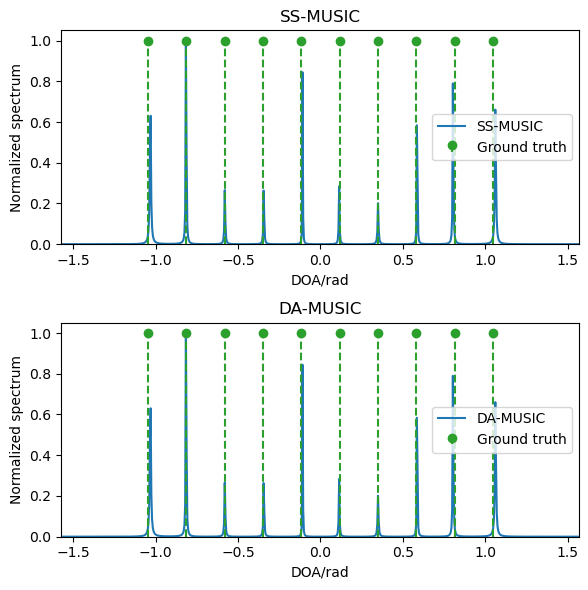

In [7]:
acm_builder = estimation.CoarrayACMBuilder1D(cpa)
virtual_ula = acm_builder.get_virtual_ula()

Rss = acm_builder.transform(R, 'ss')
Rda = acm_builder.transform(R, 'da')
music = estimation.MUSIC(virtual_ula, wavelength, grid)
resv_ss, est_ss, sp_ss = music.estimate(Rss, sources.size, return_spectrum=True)
resv_da, est_da, sp_da = music.estimate(Rda, sources.size, return_spectrum=True)

plt.figure(figsize=(6, 6))
ax = plt.subplot(2, 1, 1)
doaplt.plot_spectrum({'SS-MUSIC': sp_ss}, grid, ax=ax, ground_truth=sources)
ax.set_title('SS-MUSIC')
ax = plt.subplot(2, 1, 2)
doaplt.plot_spectrum({'DA-MUSIC': sp_da}, grid, ax=ax, ground_truth=sources)
ax.set_title('DA-MUSIC')
plt.tight_layout()
plt.show()

## Use sparse recovery

In [ ]:
scm = estimation.SparseCovarianceMatching(
    cpa, wavelength, grid, formulation='penalizedl1'
)
# Regularization parameter.
l = 8.0
resv_sr, est_sr, sp_sr = scm.estimate(
    R, sources.size, l, return_spectrum=True
)

plt.figure()
ax = plt.subplot(1, 1, 1)
doaplt.plot_spectrum({'Sparse': sp_sr}, grid, ax=ax, ground_truth=sources)
ax.set_title('Sparse recovery')
plt.show()

C:\Users\A\.conda\envs\doa_py\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:254: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(
